# EMNIST

In [1]:
# Import dependencies
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import torchvision
import seaborn as sns
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch
from tqdm import tqdm
from datetime import datetime
import yaml
import h5py
from copy import deepcopy
from project.models.cvae import *

/home/nislah/.vmgr_repo/dev-2021-02-py38/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [2]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Seed for reproducibility
torch.manual_seed(42)
print(device)

cuda


In [3]:
!ls

__init__.py  train_EMNIST_cvae.py  train_template.py
tb_logs      train_EMNIST.ipynb


In [4]:
# Create the working directory from timestamp and model name
model_name = 'cvae_emnist' # invertible network
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
workingDir = f'tb_logs/{model_name}_{timestamp}'
os.mkdir(workingDir)

In [5]:
# Create configuration file
configDict = {
'workingDir': workingDir,
'timestamp' : timestamp,
#'dataset': 'MNIST', # Define working dataset
'model': model_name, # Model
'lr': 1e-3, # Learning rate
'batch_size': 64,
'n_epochs': 50,
'kernel_size': 4, # kernel size
"init_channels": 8, # initial number of filters
"image_channels": 1, # 1 for MNIST (grayscale)
"latent_dim": 4 # latent dimension for sampling
}

with open(f'{workingDir}/config.yaml', 'w') as file:
    documents = yaml.dump(configDict, file)

In [6]:
# Load configuration file
with open(f'{workingDir}/config.yaml','r') as file:
    params = yaml.load(file, Loader=yaml.FullLoader)
params

{'batch_size': 64,
 'image_channels': 1,
 'init_channels': 8,
 'kernel_size': 4,
 'latent_dim': 4,
 'lr': 0.001,
 'model': 'cvae_emnist',
 'n_epochs': 50,
 'timestamp': '20220118_124928',
 'workingDir': 'tb_logs/cvae_emnist_20220118_124928'}

In [7]:
# Import parameters and construct model and optimizers
lr=params['lr']
batch_size=params['batch_size']
n_epochs=params['n_epochs']
kernel_size=params['kernel_size'] # kernel size
init_channels=params['init_channels'] # initial number of filters
image_channels=params['image_channels'] # 1 for MNIST (grayscale)
latent_dim=params['latent_dim'] # latent dimension for sampling
TRAIN_CVAE = True
TRAIN_VAE = False
PLOT_VAE = False
TRAIN_READOUT = False
TRAIN_READIN = False

In [8]:
# Define datasets
# Prepare the data loader for the MNIST dataset:
transform = transforms.Compose([transforms.ToTensor()])#,  transforms.Resize((32,32))]) # Dataset transform #  lambda x: (x>0.5).float(),
dataset = datasets.EMNIST(root='/share/datasets', download=False, split='letters', train=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [100000, 24800])
test_set = datasets.EMNIST(root='/share/datasets', download=False, split='letters', train=False, transform=transform)
# dataset = datasets.MNIST(root='/share/datasets', download=False, train=True, transform=transform)
# train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])

# Dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=12, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=12, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=12, shuffle=False)

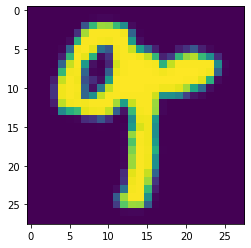

In [9]:
plt.imshow(next(iter(train_loader))[0][0].permute(1,2,0))
x,t=next(iter(train_loader))
x0,t0=x[0],t[0]

In [10]:
# !tensorboard --logdir=./tb_logs

In [11]:
tb_logger = TensorBoardLogger('tb_logs', name=model_name)
enc_layers = [28*28, 512]
dec_layers = [512, 28*28]
model = EMNIST_CVAE(latent_dim, enc_layers, dec_layers, n_classes=26, conditional=True).to(device)
print(model)
trainer = pl.Trainer(
                     gpus=1,
                     logger=tb_logger,
                     max_epochs=100,
#                      callbacks=[
#                          pl.callbacks.early_stopping.EarlyStopping(
#                              monitor='Val/Loss',
#                              mode='min',
#                              patience=5
#                          )
#                      ],
                    auto_lr_find=True)
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type           | Params
-------------------------------------------
0 | encoder | EMNIST_Encoder | 419 K 
1 | decoder | EMNIST_Decoder | 418 K 
-------------------------------------------
837 K     Trainable params
0         Non-trainable params
837 K     Total params
3.350     Total estimated model params size (MB)


EMNIST_CVAE(
  (encoder): EMNIST_Encoder(
    (MLP): Sequential(
      (L0): Linear(in_features=810, out_features=512, bias=True)
      (A0): ReLU()
    )
    (fc_mu): Linear(in_features=512, out_features=4, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=4, bias=True)
  )
  (decoder): EMNIST_Decoder(
    (MLP): Sequential(
      (L0): Linear(in_features=30, out_features=512, bias=True)
      (A0): ReLU()
      (L1): Linear(in_features=512, out_features=784, bias=True)
      (sigmoid): Sigmoid()
    )
  )
)
Epoch 0:  80%|████████████████████████████████████████████████▊            | 1563/1951 [00:07<00:01, 206.06it/s, loss=194, v_num=2]
Validating: 0it [00:00, ?it/s]
Epoch 1:  36%|██████████████████████▏                                       | 698/1951 [00:04<00:07, 172.52it/s, loss=189, v_num=2]

/home/nislah/.vmgr_repo/dev-2021-02-py38/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:895: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


Epoch 1:  36%|██████████████████████▌                                        | 698/1951 [00:16<00:30, 41.35it/s, loss=189, v_num=2]